<a href="https://colab.research.google.com/github/djgnatzy/MakeAIWork2/blob/main/apple_disease_classification_w__augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/data'

/content/drive/.shortcut-targets-by-id/1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs/data


In [ ]:
!gdown -- "1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1DQIzo_cjXQXSNKb7CeB7ipGp5aysmbbs 



In [7]:
directory='drive/My Drive/data/Train'

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
keras = tf.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This convolutional neural network uses a dataset of about 850 photos of apples. The dataset contains four sub-directories, one per class:

```
data/
  Train/
    Blotch_Apple/
    Normal_Apple/
    Rot_Apple/
    Scab_Apple/
```

In [9]:
import pathlib
data_dir = '/content/drive/My Drive/data/train'   #'drive/My Drive/data/Train'

data_dir = pathlib.Path(data_dir) 

In [10]:
print(type(data_dir))

<class 'pathlib.PosixPath'>


In [ ]:
# import os

# folder = data_dir #'data/Train/Blotch_Apple/'
# count = 1
# # count increase by 1 in each iteration
# # iterate all files from a directory
# for file_name in os.listdir(folder):
#     # Construct old file name
#     source = folder + file_name

#     # Adding the count to the new file name and extension
#     destination = folder + "blotch_" + str(count) + ".jpg"

#     # Renaming the file
#     os.rename(source, destination)
#     count += 1

# print('All files renamed')

# print('New names are:')
# # verify the result
# result = os.listdir(folder)
# print(result)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

380


Here are some roses:

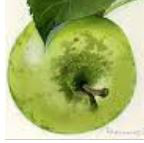

In [12]:
blotches = list(data_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotches[0]))

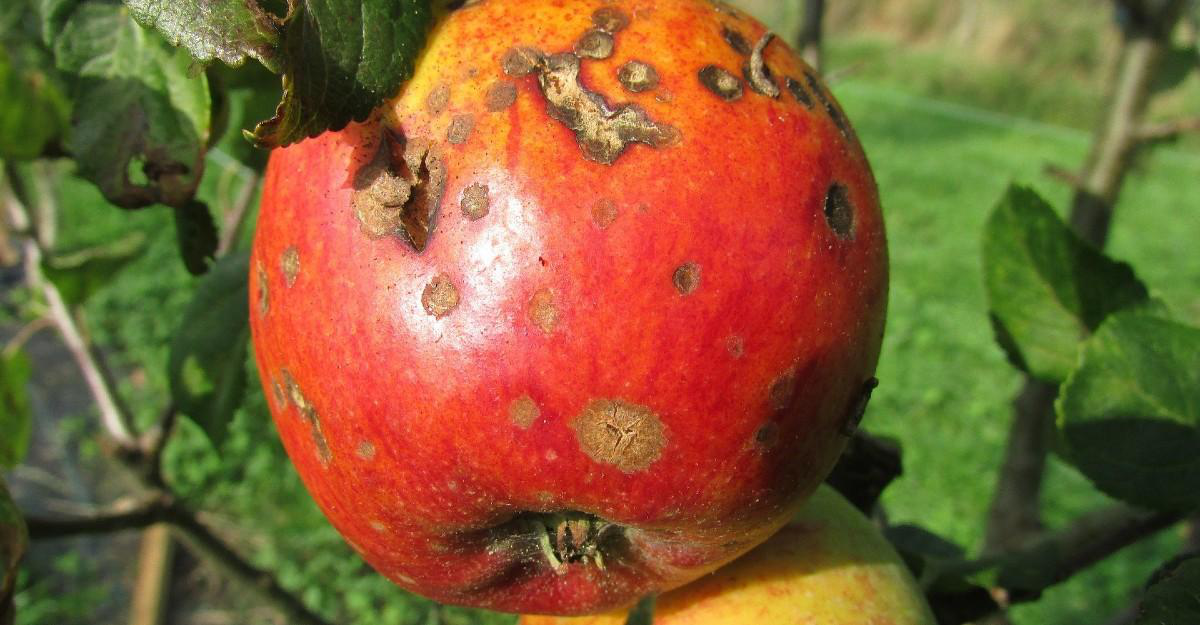

In [13]:
PIL.Image.open(str(blotches[1]))

And some tulips:

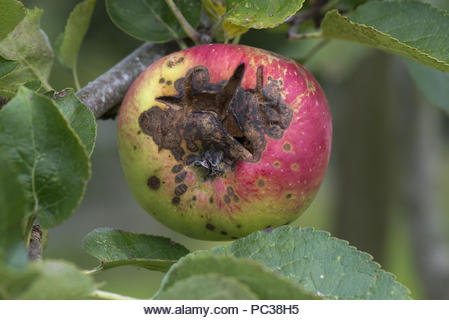

In [14]:
scabs = list(data_dir.glob('Scab_Apple/*'))
PIL.Image.open(str(scabs[0]))

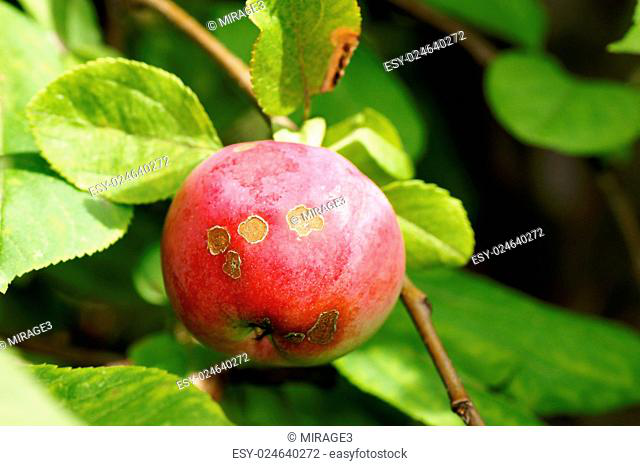

In [15]:
PIL.Image.open(str(scabs[50]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 360
img_width = 360

In [17]:
data_dir = '/content/drive/MyDrive/data/train'

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [20]:
class_names = train_ds.class_names
print(class_names)

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


## Visualize the data

Here are the first nine images from the training dataset:

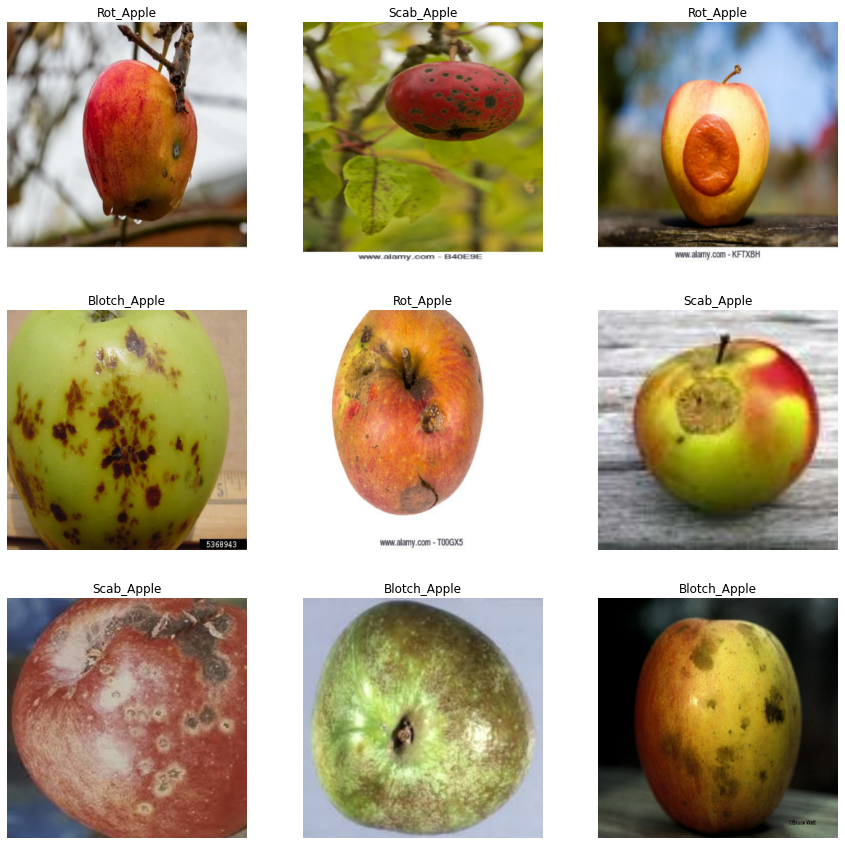

In [21]:
import matplotlib.pyplot as plt
# import random

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


    # for i in range(16):
    #     plt.subplot(4, 4, i+1)
    #     plt.xticks([])
    #     plt.yticks([])
    #     plt.grid(False)
    #     randomImage = random.randint(1, 848)
    #     plt.imshow(imageObjects[randomImage])
    #     plt.xlabel(labelNames[labelNumbers[randomImage]]) 

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# # Add the image to a batch.
# image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [ ]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(image)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 360, 360, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 180, 180, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 64)      

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/15
10/10 [==============================] - 1s 106ms/step - loss: 2.9681 - accuracy: 0.2769 - val_loss: 1.2549 - val_accuracy: 0.4342
Epoch 2/15
10/10 [==============================] - 1s 90ms/step - loss: 1.0735 - accuracy: 0.5928 - val_loss: 0.9195 - val_accuracy: 0.6184
Epoch 3/15
10/10 [==============================] - 1s 90ms/step - loss: 0.7799 - accuracy: 0.7231 - val_loss: 0.8619 - val_accuracy: 0.6447
Epoch 4/15
10/10 [==============================] - 1s 89ms/step - loss: 0.4995 - accuracy: 0.8404 - val_loss: 1.0081 - val_accuracy: 0.6184
Epoch 5/15
10/10 [==============================] - 1s 90ms/step - loss: 0.3923 - accuracy: 0.8762 - val_loss: 0.8512 - val_accuracy: 0.7105
Epoch 6/15
10/10 [==============================] - 1s 90ms/step - loss: 0.2252 - accuracy: 0.9381 - val_loss: 1.1027 - val_accuracy: 0.7237
Epoch 7/15
10/10 [==============================] - 1s 90ms/step - loss: 0.2096 - accuracy: 0.9251 - val_loss: 1.1314 - val_accuracy: 0.6447
Epoch 8/15
1

In [ ]:
print(len(history.history['loss']))

10


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

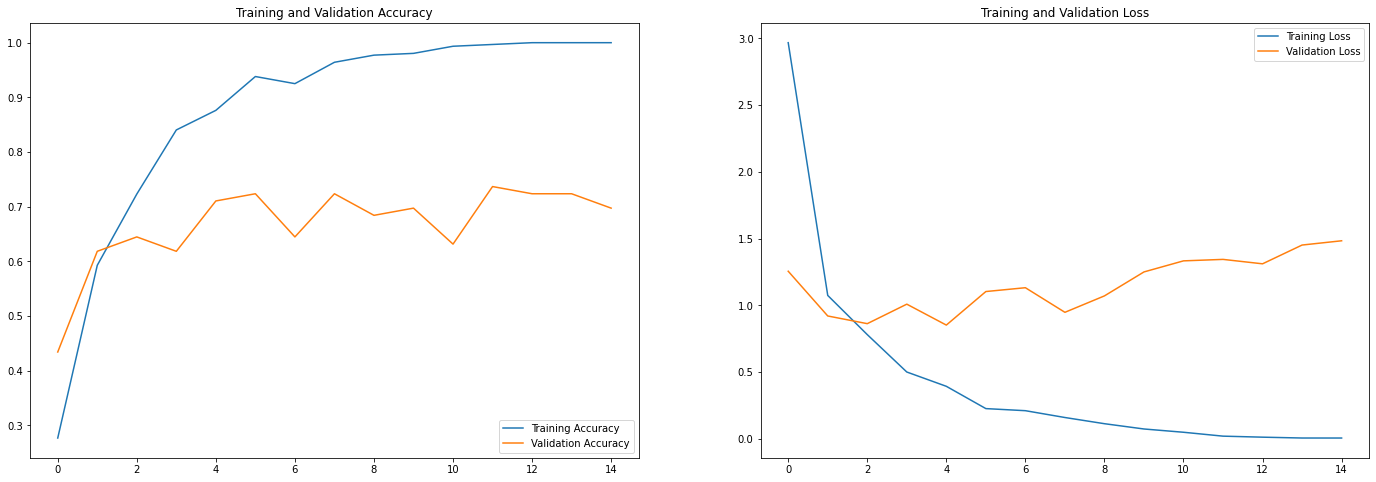

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

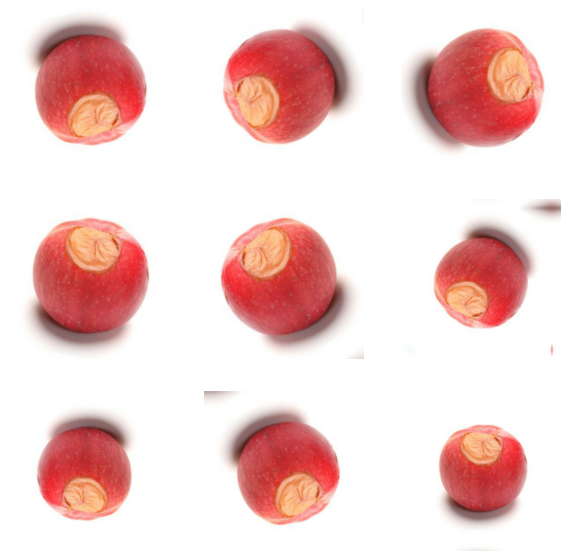

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images, training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [26]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(images, 0), tf.float32)

You will add data augmentation to your model before training in the next step.

## Batch Normalization

In [ ]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=False,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [27]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 360, 360, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 360, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 180, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

In [30]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
10/10 [==============================] - 26s 2s/step - loss: 14.8953 - accuracy: 0.2508 - val_loss: 1.3612 - val_accuracy: 0.2632
Epoch 2/10
10/10 [==============================] - 1s 96ms/step - loss: 1.2798 - accuracy: 0.4202 - val_loss: 1.2494 - val_accuracy: 0.5526
Epoch 3/10
10/10 [==============================] - 1s 95ms/step - loss: 1.1330 - accuracy: 0.5049 - val_loss: 1.2054 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 1s 96ms/step - loss: 0.9941 - accuracy: 0.5993 - val_loss: 1.1144 - val_accuracy: 0.5132
Epoch 5/10
10/10 [==============================] - 1s 95ms/step - loss: 0.8703 - accuracy: 0.6612 - val_loss: 1.0312 - val_accuracy: 0.5395
Epoch 6/10
10/10 [==============================] - 1s 96ms/step - loss: 0.7530 - accuracy: 0.7166 - val_loss: 0.9377 - val_accuracy: 0.5921
Epoch 7/10
10/10 [==============================] - 1s 95ms/step - loss: 0.6181 - accuracy: 0.7752 - val_loss: 0.9047 - val_accuracy: 0.6579
Epoch 8/10
10

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

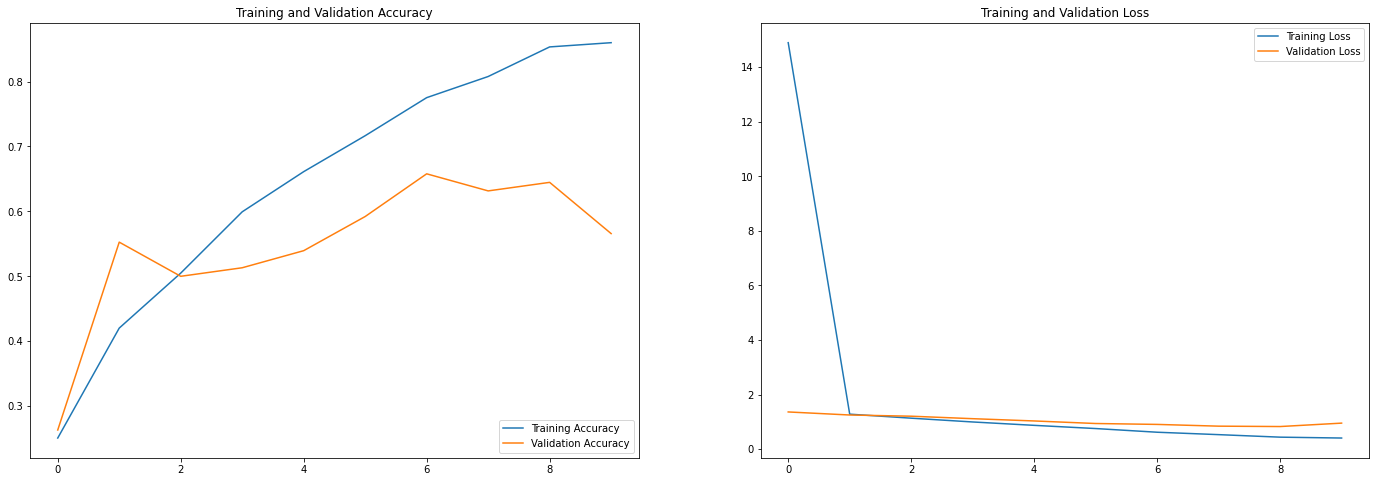

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [35]:
sunflower_url = "https://ehonami.blob.core.windows.net/media/2014/11/greenapple110314-1024x680.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to Scab_Apple with a 86.98 percent confidence.


119
<class 'pathlib.PosixPath'>


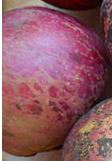

In [37]:
import pathlib
test_dir = '/content/drive/My Drive/data/test'
test_dir = pathlib.Path(test_dir) 
image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)
print(type(test_dir))
blotchez = list(test_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotchez[1]))

In [ ]:
model.predict(testSet)

In [ ]:
predictionBatch = model.predict(testSet)
predictionEnhanced = np.argmax(predictionBatch, axis=-1)

print(predictionEnhanced)

labels = np.argmax(testLabels,axis=-1)

print(classification_report(labels, pred))

conf_matrix = tf.math.confusion_matrix(labels=testLabels, predictions=predictionEnhanced)

# print(conf_matrix)

In [ ]:
actual = testLabels
predicted = predictionEnhanced

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Highway", "River"])
# Origineel: display_labels = [False, True]

cm_display.plot()
plt.show()

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).